# Exercise 8 - Image Processing in Fourier Plane
## 12.12.18
### Hagai Har-Gil

In [1]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

## Mathematical Introduction

### Delta functions and sampling

The definition of a discrete delta function is as follows:

$$
\delta(x) = \begin{cases}
1, & x = 0 \\
0, & x \neq 0
\end{cases}
$$

The delta function has a _sifting_ property:

$$
\sum_{x=- \infty}^{\infty}{f(x) \delta(x)} = f(0) \\
\sum_{x = - \infty}^{\infty}{f(x) \delta(x-x_0)} = f(x_0)
$$

How do we sample a continuous function into the discrete world?

$$
f[t] = f(t)_{\text{discrete}} = \sum_{n= - \infty}^{\infty}{f(t)\delta(t - n dt)}
$$

![Sampling](ImagesExtraMaterial\sampling.png "Sampling")

If our new sampled signal consists of N samples of $f(t)$, taken $dt$ apart, the duration of the sampled signal is $T = Ndt$.

The spacing in the frequency domain will be $df = \frac{1}{Ndt} = \frac{1}{T}$ (which is also the fundemental frequency), and the entire frequency range will be spanned with $N$ components, with the final frequency being $\frac{1}{dt}$. Let's input some numbers to make it understandable:

$$
N = 5000, dt = 0.001 \text{s} \\
T = Ndt = 5 \text{ seconds} \\
df = \frac{1}{Ndt} = \frac{1}{T} = \frac{1}{5} = 0.2 \text{ Hz  (makes sense, doesn't it?)} \\
f_\text{max} = \frac{1}{dt} = 1000 \text{ Hz}
$$


If the function we're converting to the frequency domain doesn't have any spectral components beyond some threshold, the function is called _band-limited_. We're guaranteed to model this function properly in the frequency domain if $f_\text{max}/2 > f_\text{signal}$, or in other words, if our Nyquist frequency is greater than the largest frequency in the signal.

Since band-limited signals will be sampled correctly, the process of _anti-aliasing_ is done pre-sampling, to make sure that there are no unwanted frequency components above our Nyquist limit.

### From 1D to 2D

The continuous and inverse transforms:
$$ 
F(\omega)=\frac{1}{2\pi}\int_{-\infty}^{\infty}{f(t)e^{-i\omega t}}dt \\
f(t) = \int_{-\infty}^{\infty}{F(\omega) e^{i\omega t} dt}
$$

The discrete transform is very similar:

$$
F[k] = \sum_{n=0}^{N-1}{f[n] \exp{\left(-i \frac{2\pi n k}{N}\right)}} \ ; \ k \in [0, N-1] \\
f[n] = \frac{1}{N} \sum^{N-1}_{k=0}{F[k]}\exp{\left(\frac{{2\pi i k n}}{N}\right)} \ ; \ n \in [0, N-1]
$$

For example, the Fourier transform of a rectangular pulse (boxcar):

$$
f(t) = \begin{cases}
A, & -W/2 < t < W/2 \\
0, & \text{else}
\end{cases} \\
F(\omega) = \int_{- \infty}^{\infty}{f(t)e^{-2 \pi i \omega t}dt} = \int_{-W/2}^{W/2}{Ae^{-2 \pi i \omega t}dt} = \\
= AW \frac{\sin{(\pi \omega W)}}{\pi \omega W} = AW \text{sinc}(\pi \omega W)
$$

![Fourier of boxcar](ImagesExtraMaterial\averaging.png "Fourier of boxcar")

Why is the relation between the width in the frequency and time domain reciprocal? If we average over the _entire_ sample, only the very low frequencies will have any effect. On the contrary, if don't average at all (=average a single bin) all available frequencies will "survive" the transform.

---

Generalizing the Fourier formula to two dimensions is pretty trivial:

$$
F[k,l] = \sum_{n_1=0}^{N-1} \sum_{n_2=0}^{M-1}{f[n_1,n_2] \exp{\left( -2 \pi i \left( \frac{kn_1}{N} + \frac{ln_2}{M} \right) \right)}}
$$

That being said, we're obviously not going to prove it here. 

### Magnitude and phase

Keeping Euler's formula in mind,

$$
e^{i\theta} = \cos \theta + i \sin \theta
$$
we can write the DFT of the signal in a different way (reverting to 1D for ease of explanation):

$$
F[k] = \sum_{n=0}^{N-1}{f[n] \left( \cos(2\pi k n / N) - i\sin (2\pi k n / N) \right)}
$$
allowing us to identify the real and imaginary part of a Fourier-transformed signal more easily. Writing it in polar coordinates results in:

$$
F[k] = \left| F[k] \right| e^{-i\phi(k)}
$$
where 

$$
\left| F[k] \right| = \left[ \Re^2(k) + \Im^2(k) \right]^{1/2}
$$
is the _magnitude_ of the Fourier transform, and

$$
\phi(k) = \tan^{-1} \left[ \frac{\Im(k)}{\Re(k)} \right]
$$
is the _phase_. Note that $\Re$ denotes the real part of the signal, and $\Im$ the imaginary. Another useful definition, which we've already seen as well, is the _power spectrum_:

$$
P(k) = \left| F[k] \right|^2 = \Re^2(k) + \Im^2 (k)
$$
sometimes normalized by $N$.

For real signals, like our images, the transform is conjugate symmetric: 

$$
F[k,l] = F^*[-k, -l] \Rightarrow \left| F[k,l] \right| = \left| F[-k,-l] \right|
$$


That's why shifting the $(0,0)$ point of the transform, that indicates the DC signal, to the center of the image is so common - it creates a symmetric image in the Fourier plane. The DC component is:

$$
F[0,0] = \frac{1}{MN}\sum_{n_1=0}^{N} \sum_{n_2=0}^{M} {f[n_1, n_2]}
$$
which is just the average of the 2D function across space.


### Implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
%matplotlib inline

Text(0.5, 1.0, 'Image of 2D cosine wave')

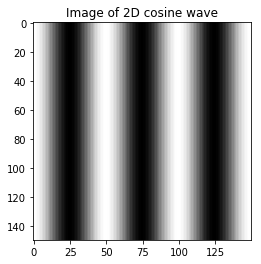

In [3]:
image_size_cos = 150  # pixels
freq = 3  # Hz

t = np.linspace(start=0, stop=image_size_cos, num=image_size_cos)
one_d_cos = np.cos(2 * np.pi * freq * t)
two_d_cos = np.ones((image_size_cos, image_size_cos))
two_d_cos *= one_d_cos  # broadcasting makes it easy
plt.imshow(two_d_cos, cmap='gray')
plt.title('Image of 2D cosine wave')

/home/hagaihargil/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Text(0.5, 1.0, 'Fourier transform of a 2D cosine signal')

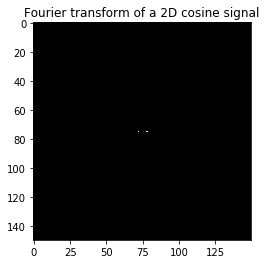

In [4]:
cosine_fourier = fftpack.fftshift(fftpack.fft2(two_d_cos))
cosine_fourier_magnitude = np.power(np.abs(cosine_fourier), 2)
plt.imshow(cosine_fourier_magnitude, cmap='gray')
plt.title('Fourier transform of a 2D cosine signal')

The farther apart the dots are, the higher frequencies they represent. The maximal frequency of an image is just a grid in which pixel $x$ is black, while pixels $x-1$ and $x+1$ are white.

---
Let's look at a different known example:

Text(0.5, 1.0, 'Rotated cosine pattern')

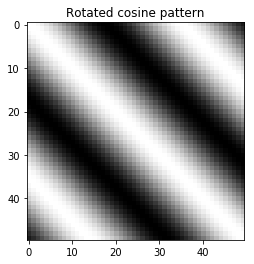

In [5]:
from skimage import transform
rotated_image_size = image_size_cos // 3
freq = 6  # Hz

t = np.linspace(start=0, stop=image_size_cos, num=image_size_cos)
one_d_cos = np.cos(2 * np.pi * freq * t)
two_d_cos = np.ones((image_size_cos, image_size_cos))
two_d_cos *= one_d_cos
rotated_cos = transform.rotate(two_d_cos, angle=45)  # In Matlab - imrotate
rotated_cos = rotated_cos[rotated_image_size:(2 * rotated_image_size),
                          rotated_image_size:(2 * rotated_image_size)]
plt.imshow(rotated_cos, cmap='gray')
plt.title('Rotated cosine pattern')

/home/hagaihargil/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Text(0.5, 1.0, 'Fourier transform of a 2D rotated cosine signal')

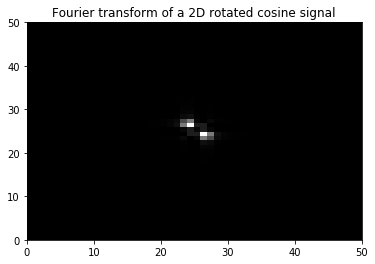

In [6]:
cosine_fourier_rotated = fftpack.fftshift(fftpack.fft2(rotated_cos))
cosine_fourier_rotated_magnitude = np.power(np.abs(cosine_fourier_rotated), 2)
plt.pcolor(cosine_fourier_rotated_magnitude, cmap='gray')
plt.title('Fourier transform of a 2D rotated cosine signal')

---
A more familiar example: A rectangle.

In [7]:
image_size = 512
rect_a = 20
rect_b = 10

image_plane = np.zeros((image_size, image_size))

# Creating a rectangle
image_plane[(image_size//2 - rect_a//2):(image_size//2 + rect_a//2),
            (image_size//2 - rect_b//2):(image_size//2 + rect_b//2)] = 1

Text(0.5, 1.0, 'Rectangle in the image plane')

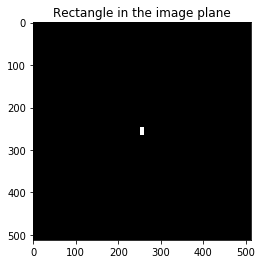

In [8]:
plt.imshow(image_plane, cmap='gray')
plt.title('Rectangle in the image plane')

Text(0.5, 1.0, 'Fourier transform of rectangle')

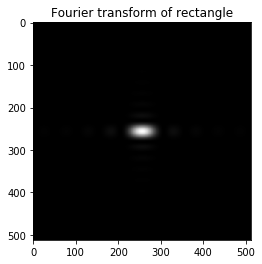

In [9]:
image_fourier = fftpack.fftshift(fftpack.fft2(image_plane))
image_fourier_magnitude = np.power(np.abs(image_fourier), 2)
image_fourier_magnitude[image_fourier_magnitude == 0] = 1e-10  # avoids division by 0
plt.imshow(image_fourier_magnitude, cmap='gray')
plt.title('Fourier transform of rectangle')

The strong DC component overshadows the rest of the figure. A simple $\log$ operation on the image can yield a better-looking result:

Text(0.5, 1.0, 'Fourier magnitude spectrum of the rectangle in log-scale')

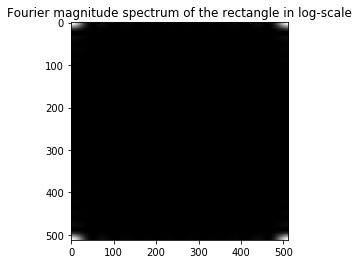

In [10]:
plt.imshow(np.log10(image_fourier_magnitude), cmap='gray')
plt.imshow(fftpack.ifftshift(image_fourier_magnitude), cmap='gray')
plt.title('Fourier magnitude spectrum of the rectangle in log-scale')

What are the properties of this plot?
* The rectangle seems to be "reversed" - happens due to the mathematical properties of the transform. It's the same phenomenon we've seen with the boxcar before.
* The data displayed is in the range [-Fs/2, Fs/2]
* This is the magnitude - and it's a $\text{sinc}$ function. 

Text(0.5, 1.0, 'The result of a Fourier transform of a rectangle in 1D')

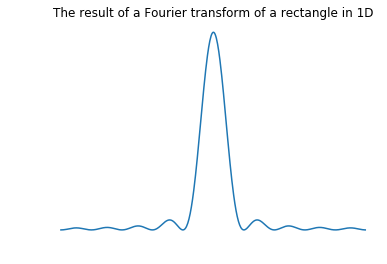

In [11]:
plt.plot(image_fourier_magnitude[image_size//2, :])
plt.axis('off')
plt.title('The result of a Fourier transform of a rectangle in 1D')

## Examples with "real" images

### Hubble deep field

In [12]:
from skimage import data
from skimage import color

Text(0.5, 1.0, 'Hubble Deep Field')

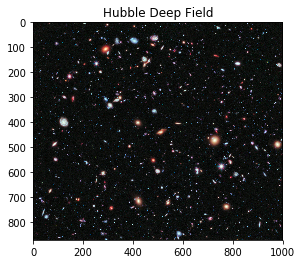

In [13]:
hubble = data.hubble_deep_field()
plt.imshow(hubble, cmap='viridis')
plt.title('Hubble Deep Field')

Text(0.5, 1.0, 'Fourier transform of many delta functions')

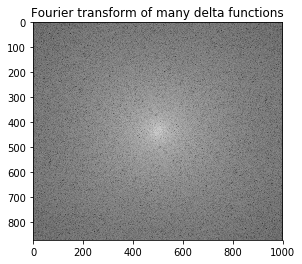

In [14]:
hubble_fourier = fftpack.fftshift(fftpack.fft2(color.rgb2gray(hubble)))
hubble_fourier_abs = np.power(np.abs(hubble_fourier), 2)
plt.imshow(np.log10(hubble_fourier_abs), cmap='gray')
plt.title('Fourier transform of many delta functions')

We see her some sort of averaging of many point-like structures, resulting in a smeared pattern of a delta function.

### Cup of coffee

Text(0.5, 1.0, 'Cup of coffee')

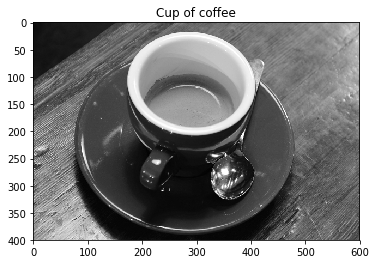

In [15]:
cof = data.coffee()
plt.imshow(color.rgb2gray(cof), cmap='gray')
plt.title('Cup of coffee')

Text(0.5, 1.0, 'Magnitude of Fourier transform of the cup of coffee')

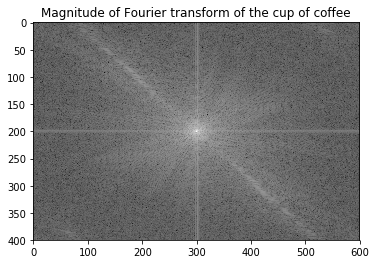

In [16]:
cof_fourier = fftpack.fftshift(fftpack.fft2(color.rgb2gray(cof)))
cof_fourier_abs = np.power(np.abs(cof_fourier), 2)
plt.imshow(np.log10(cof_fourier_abs), cmap='gray')
plt.title('Magnitude of Fourier transform of the cup of coffee')

### Phase spectrum

Let's observe the phase of the transformed image:

Text(0.5, 1.0, 'The phase spectrum of the cup of coffee')

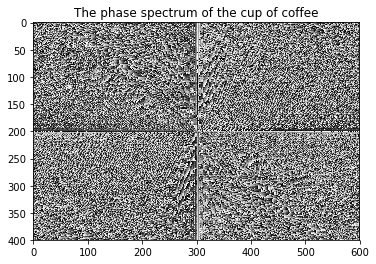

In [17]:
cof_fourier_phase = np.angle(cof_fourier)  # Same in Matlab
plt.imshow(cof_fourier_phase, cmap='gray')
plt.title('The phase spectrum of the cup of coffee')

It's obviously indiscernible. The nice thing about the frequency spectrum is that it contains more information than the magnitude spectrum for visualization. Let's switch the phase and magnitude of the cup of two images, and see what we get (think of how are we about to do it):

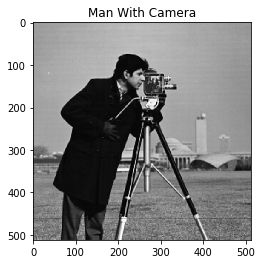

In [18]:
camera = data.camera()
plt.imshow(camera, cmap='gray')
plt.title('Man With Camera')

# Take the phase spectrum only
camera_fourier = fftpack.fft2(camera)
camera_phase = np.angle(camera_fourier)

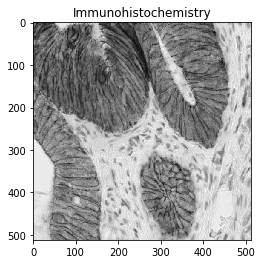

In [19]:
ihc = data.immunohistochemistry()
ihc = ihc[:,:,1]
plt.imshow(ihc, cmap='gray')
plt.title('Immunohistochemistry')

# Take the magnitude spectrum only
ihc_fourier = fftpack.fft2(ihc)
ihc_mag = np.abs(ihc_fourier)

Text(0.5, 1.0, 'The phase prevails')

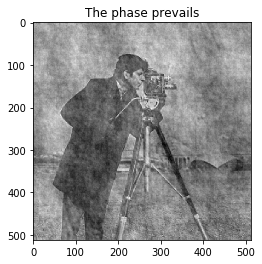

In [21]:
switched_fourier = ihc_mag * np.exp(1j * camera_phase)
# Inverse it back
switched_image = fftpack.ifft2(switched_fourier)
plt.imshow(np.real(switched_image), cmap='gray')
plt.title('The phase prevails')

## Filtering

### Basics steps:

We've already discussed filters in the one-dimensional case. Here's a reminder on how to filter a signal - an image in our case:

1. Compute the DFT of the image $F(k,l)$
2. Multiply $F(k,l)$ by the _filter function_ $H(k,l)$. 
3. Compute the inverse DFT of the result.
4. Display only the real part of the image.

Many times, preceeding step one and four will be a few "pre-processing" stages. These can include cropping the image to even sizes, zero-padding, gray-level scaling, conversion to floating point on input and 8-bit images on output

### 2D Filtering - Notch filter

Once we have a better understanding of linear systems, we can examine different types of filters in 2D:

A notch filter is a constant fnction with a hole at some frequency(ies). Let's apply a notch filter to the coffee image above:

Text(0.5, 1.0, 'A disk filter')

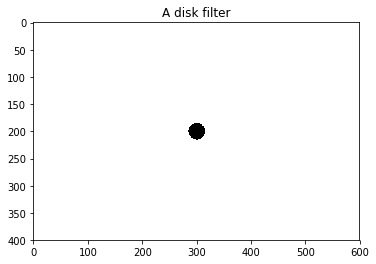

In [23]:
radius = 230
coffee_x = cof_fourier.shape[1]
coffee_y = cof_fourier.shape[0]
yg, xg = np.ogrid[-coffee_y//2:coffee_y//2, -coffee_x//2:coffee_x//2]

circle_pixels = xg**2 + yg**2 <= radius^2
filter_disk = np.ones_like(circle_pixels)
filter_disk[circle_pixels] = 0
plt.imshow(filter_disk, cmap='gray')
plt.title('A disk filter')

Text(0.5, 1.0, 'Filtered Fourier spectrum')

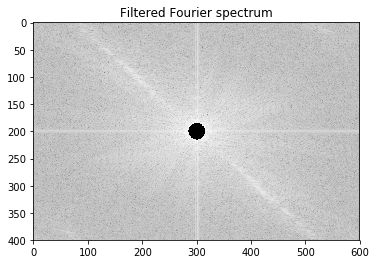

In [24]:
# Multiplying filter and image
filtered_fourier_image = cof_fourier * filter_disk
filtered_abs = np.power(np.abs(filtered_fourier_image), 2)
filtered_abs[filtered_abs == 0] = 10e-12
plt.imshow(np.log10(filtered_abs), cmap='gray')
plt.title('Filtered Fourier spectrum')

Let's view what remains of our original image:

Text(0.5, 1.0, 'Coffee cup after filtering the low frequencies')

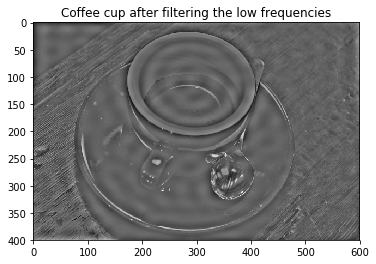

In [25]:
inversed_cof = fftpack.ifft2(fftpack.ifftshift(filtered_fourier_image))  # shift back first, then inverse the transform
plt.imshow(np.real(inversed_cof), cmap='gray')
plt.title('Coffee cup after filtering the low frequencies')

What else can we see, besides the high-pass effect?

**Ringing!** Why did it happen?

Sharp cut-offs creating the ringing, or "Gibbs phenomenon". 

![Gibbs phenomenon](ImagesExtraMaterial\gibbs.jpg "Gibbs phenomenon")

### Low-pass filter

Text(0.5, 1.0, 'Baseline astronaut picture')

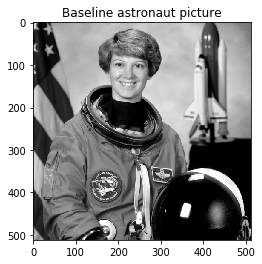

In [26]:
astro = color.rgb2gray(data.astronaut())
plt.imshow(astro, cmap='gray')
plt.title('Baseline astronaut picture')  # her name is Eileen Collins, by the way.

Text(0.5, 1.0, 'Fourier Transform of Eileen')

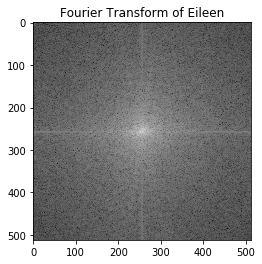

In [27]:
astro_fourier = fftpack.fftshift(fftpack.fft2(astro))
astro_fourier_abs = np.power(np.abs(astro_fourier), 2)
plt.imshow(np.log10(astro_fourier_abs), cmap='gray')
plt.title('Fourier Transform of Eileen')

You can notice a dim "harmonic" pattern in the image, generated by the additional sinusoidal signals that are needed to perform the frequency conversion. Another complimentary view on this is that the derivative of a sinusoid is a sinusoid, and to model sharp curves you need very high frequency sinusoidal signals, which are aliased into our frequency band.

Text(0.5, 1.0, 'A low-pass filter')

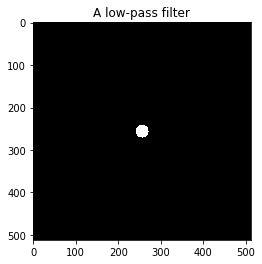

In [28]:
# Creating the low-pass filter

radius = 230
astro_x = astro_fourier.shape[1]
astro_y = astro_fourier.shape[0]
yg2, xg2 = np.ogrid[-astro_y//2:astro_y//2, -astro_x//2:astro_x//2]

circle_pixels_astro = xg2**2 + yg2**2 >= radius^2
filter_lp = np.ones_like(circle_pixels_astro)
filter_lp[circle_pixels_astro] = 0
plt.imshow(filter_lp, cmap='gray')
plt.title('A low-pass filter')

Text(0.5, 1.0, 'Filtered Fourier spectrum')

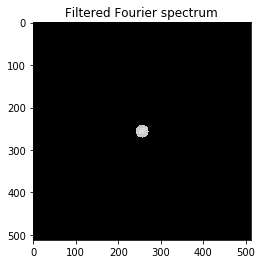

In [29]:
# Multiplying filter and image
filtered_fourier_astro = astro_fourier * filter_lp
filtered_lp_abs = np.power(np.abs(filtered_fourier_astro), 2)
filtered_lp_abs[filtered_lp_abs == 0] = 10e-12
plt.imshow(np.log10(filtered_lp_abs), cmap='gray')
plt.title('Filtered Fourier spectrum')

Text(0.5, 1.0, 'Eileen Collins after filtering the high frequencies')

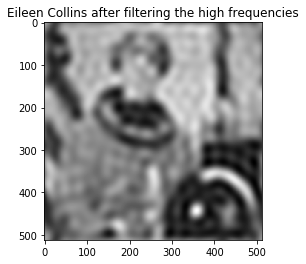

In [30]:
inversed_astro = fftpack.ifft2(fftpack.ifftshift(filtered_fourier_astro))  # shift back first, then inverse the transform
plt.imshow(np.real(inversed_astro), cmap='gray')
plt.title('Eileen Collins after filtering the high frequencies')

---
We can also do it in Fiji, if you prefer using it instead.

## Singular Value Decomposition

### Underlying linear algebra concepts

For a matrix $A$ with $n$ rows and $m$ columns, we define _eigenvectors_ and _eigenvalues_ using this equation:

$$
A\vec{v} = \lambda \vec{v}
$$

For $\vec{v}$ to be the eigenvectors of $A$, they have to be non-zero and to satisfy this equation, which also consists of the eigenvalues $\lambda$. To find these eigenvalues and eigenvectors we solve this equation as a set, or system, of linear equations. We won't go into these details (all of you should be vaguely aware of them), but after the calculation, generally each eigenvalue will have an eigenvector.

For example, a specific matrix:

$$
A = \begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$$

has an eigenvalue of $\lambda_1=3$ with an eigenvector of $\vec{v}_1=[1,1]$, and an eigenvalue of $\lambda_2=1$ with an eigenvector of $\vec{v}_2=[1,-1]$.

A theorem in linear algebra states a square matrix $A$ is diagonalizable if we can decompose it to $A=PDP^{-1}$, with $D$ being diagonal. From this follows that the columns of $P$ are its eigenvectors, and the values along the diagonal in $D$ are the eigenvalues. Of course, not all matrices are diagonalizable, since they don't always have eigenvectors that form a basis. SVD takes this concept one further step, by generalizing it to all matrices.

### SVD calculation

We start of with the fact that the matrix $A^T A$ is symmetric, and thus its eigenvectors $x_i$ form an orthonormal basis. Assuming that their corresponding eigenvalues are $\lambda_i$, we will define $\sigma_i = \sqrt{\lambda_i}$ (these are the singular values), and another vector will be denoted as $r_i = \frac{Ax_i}{\sigma_i}$.

These quantities will construct three matrices that decompose $A$: $U$ will have $r_i$ as its columns, $V$ will have $x_i$ as its columns, and $\Sigma$ will have $\sigma_i$ as its diagonal, padded with zeros if necessary. To prove that
$$
A_{mn} = U_{mm} \Sigma_{mn} V^T_{nn} \\
$$
we'll see what is the result of the multiplication done on the right-hand side:

$$
U\Sigma = \frac{Ax_i}{\sigma_i}\sigma_i = Ax_i
$$

The next step is to multiply $U\Sigma$ by $V^T$. The columns are $Ax_i$, and the rows are of the form $x_j$. Since the eigenvectors are orthonormal, if $i \neq j$ then $x_i x_j^T = 0$, and for $i = j$ we have $x_i x_i^T = 1$, which yields

$$
U\Sigma V^T = AI = A
$$

In summary, we were able to write an arbitrary matrix $A$ using three different matrices, with $U$ and $V$ having orthonormal columns and $\Sigma$ being a diagonal matrix composed of singular values.

### Data compression

When we want to compress images by $x\%$, we want the singular values that correspond to $x\%$ _of the total sum of singular values_.

We take these singular values, along with their corresponding vectors from $U$ and $V^T$. 

for an image with $n^2$ elements, we can only retain $k(2n + 1)$ elements for a rank of $k$. This equals at about $k = \frac{n}{2}$, but we'll usually take _much_ less elements than that, resulting in compression of usually over 50%.

### SVD implementation

#### Random matrix

In [31]:
from scipy import linalg

((9, 6), (6,), (6, 6))

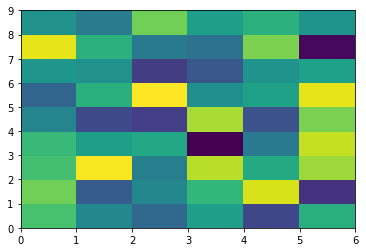

In [32]:
a = np.random.randn(9, 6)
plt.pcolor(a)
U, s, V = linalg.svd(a, full_matrices=False)  # in Matlab, svd(a)
U.shape, s.shape, V.shape

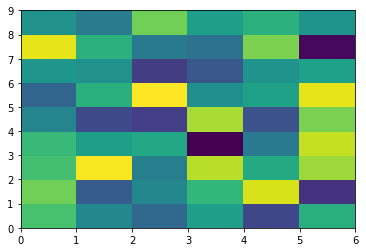

In [33]:
S = linalg.diagsvd(s, U.shape[1], U.shape[1])
a_calc = U @ S @ V  # matrix multiplication
plt.pcolor(a_calc)

#### Using a real image

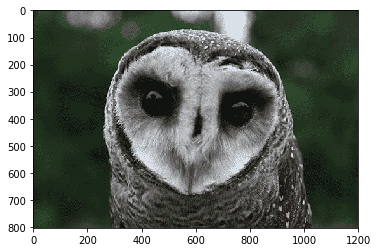

In [44]:
# Matlab source can be found in http://andrew.gibiansky.com/blog/mathematics/cool-linear-algebra-singular-value-decomposition/
owl = plt.imread(r'ImagesExtraMaterial/owl.jpg')
plt.imshow(owl)

Text(0.5, 1.0, 'Log scale of magnitude of SVD components')

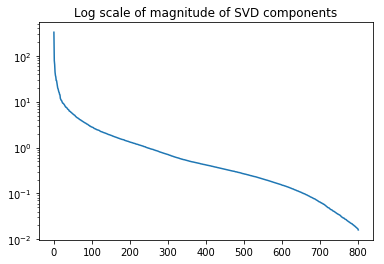

In [45]:
gray_owl = color.rgb2gray(owl)

U, s, V = linalg.svd(gray_owl)
plt.semilogy(s)
plt.title('Log scale of magnitude of SVD components')

Text(0.5, 1.0, 'Cumulative percent of total singular values')

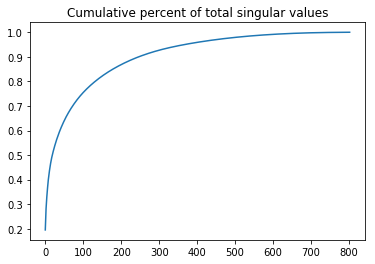

In [46]:
plt.plot(np.cumsum(s)/ np.sum(s))
plt.title('Cumulative percent of total singular values')

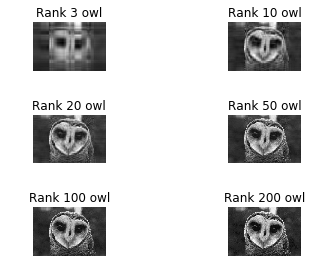

In [47]:
num_of_ranks = [3, 10, 20, 50, 100, 200]

for idx, cur_ranks in enumerate(num_of_ranks):
    cur_sigmas = s.copy()
    cur_sigmas[cur_ranks:] = 0  # Subset of the ranks
    S = linalg.diagsvd(cur_sigmas, U.shape[1], V.shape[1])
    approx_owl = U @ S @ V  # Recreate the owl
    # Plotting
    plt.subplot(3, 2, idx+1)
    plt.imshow(approx_owl, cmap='gray')
    plt.title('Rank {} owl'.format(cur_ranks))
    plt.axis('off')

plt.tight_layout()